In [1]:
TRAIN_INPUT = 'twitgen_train_201906011956.csv'
VALID_INPUT = 'twitgen_valid_201906011956.csv'
TEST_INPUT = 'twitgen_test_201906011956.csv'
EMBEDDING_DIM = 200
MAXLEN = 50  # Maximum number of words per tweet that will be processed
MODEL_NAME = 'PoolModel_201907041941.h5'

In [2]:
basepath = '../data/'

In [3]:
import tensorflow as tf
import pandas as pd
import os
import re
import keras
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
from keras.optimizers import Adam, Adagrad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from datetime import datetime
import string

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [4]:
# Read in the data
df_train = pd.read_csv(basepath+TRAIN_INPUT, index_col=['id','time'], parse_dates=['time'])
df_valid = pd.read_csv(basepath+VALID_INPUT, index_col=['id','time'], parse_dates=['time'])
df_test = pd.read_csv(basepath+TEST_INPUT, index_col=['id','time'], parse_dates=['time'])
df_train.head()

,,text,male
id,time,,
1083596943807393792,2019-05-27 23:27:08+00:00,"Ah, the Flat Earth gambit.\nWell played.",True
815783987784187904,2019-05-24 15:36:01+00:00,Aw ily,False
3458239641,2019-05-24 19:00:37+00:00,I hate being sick,False
1003729876250226688,2019-05-26 12:53:00+00:00,You still didn't' do shit tho. Slow down the...,True
2360143940,2019-05-28 03:50:46+00:00,Harriet Tubman may not be on the $20 bill... f...,False


In [5]:
# Maximum number of words per tweet in each data set
(df_train.text.str.split().apply(len).max(), 
 df_valid.text.str.split().apply(len).max(),
 df_test.text.str.split().apply(len).max())

(34, 30, 31)

In [6]:
# Text Normalization function

# Taken from 
# https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
# which was taken from https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
# but this version no longer does stemming or stop word elmination

# This is for general text, not Twitter-specific.
# Maybe would get a better classifier if we used a Python transaltion of this:
# https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
# but that is arguably outside the scope of this project
# and my initial attempts to use Twitter-specific preprocessing have been unsuccessful


def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


In [7]:
# Process the data for model input
def get_texts_and_labels(df):
  texts = df['text'].map(lambda x: clean_text(x)).tolist()
  texts = [t.split()[0:MAXLEN] for t in texts]
  labels = df['male'].tolist()
  return texts, labels

train_text, train_label = get_texts_and_labels(df_train)
valid_text, valid_label = get_texts_and_labels(df_valid)
test_text, test_label = get_texts_and_labels(df_test)

max([len(x) for x in train_text]), max([len(x) for x in valid_text]), max([len(x) for x in test_text])

(47, 42, 42)

In [8]:
# Fit tokenizer on training data
tok = Tokenizer()
tok.fit_on_texts(train_text)
vocab_size = len(tok.word_index) + 1

In [9]:
# Tokenize the data
def get_tokenized_texts(texts):
  encoded_docs = tok.texts_to_sequences(texts)
  padded_docs = pad_sequences(encoded_docs, maxlen=MAXLEN, padding='post')
  return padded_docs

docs_train = get_tokenized_texts(train_text)
docs_valid = get_tokenized_texts(valid_text)
docs_test = get_tokenized_texts(test_text)

print(type(docs_train), len(docs_train), len(docs_valid), len(docs_test))
docs_train[0][:10]

<class 'numpy.ndarray'> 34146 10914 10450


array([  956,     1,  4035,  1154, 13312,     8,    98,   732,     0,
           0], dtype=int32)

In [10]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))  # Dummy to create model; will be filled by loading from disk

In [11]:
# NERUAL NETWORK MODEL

# PARAMETERS

batchsize = 512

temporal_dropout = .2
random_dropout = .1
flat_dropout= .3

frozen_lr = 1e-3
frozen_decay = 1e-4
frozen_epochs = 12

unfrozen_lr = 3e-4
unfrozen_decay = 3e-5
unfrozen_epochs = 25
unfrozen_batchsize = batchsize


inputs = layers.Input((MAXLEN,), dtype="int32")

# EMBEDDING BLOCK
raw_embed = layers.Embedding(vocab_size, 
                           EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAXLEN, 
                           trainable=False)(inputs)
embed_random_drop = layers.Dropout(rate=random_dropout)(raw_embed)
embed_time_drop = layers.Dropout(rate=temporal_dropout, 
                       noise_shape=(None, MAXLEN, 1))(embed_random_drop)

max_pooled = layers.GlobalMaxPooling1D()(embed_time_drop)
av_pooled = layers.GlobalAveragePooling1D()(embed_time_drop)
pooled = layers.merge.concatenate([max_pooled,av_pooled], name='pooled')
drop_pooled = layers.Dropout(rate=flat_dropout)(pooled)

pred = layers.Dense(1, activation='sigmoid')(drop_pooled)

# FINAL MODEL
model = Model(inputs=[inputs], outputs=pred)
model.compile(optimizer=Adam(frozen_lr, decay=frozen_decay), 
              loss='binary_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 200)      6026200     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)  

In [12]:
model.load_weights(basepath + MODEL_NAME)

In [13]:
test_preds = model.predict(docs_test)
y_test = test_label
print('Test set confusion matrix:')
print( confusion_matrix(y_test, (test_preds>.5)))
print('Test set F1 score: {}'.format(f1_score(y_test, test_preds>.5)))
print('Test set accuracy: {}'.format(accuracy_score(y_test, test_preds>.5)))
fpr, tpr, _ = roc_curve(y_test, test_preds)
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))

Test set confusion matrix:
[[3156 2069]
 [2130 3095]]
Test set F1 score: 0.5958225045721436
Test set accuracy: 0.5981818181818181
Test set ROC AUC: 0.6473898491334906


Test set ROC AUC: 0.6473898491334906


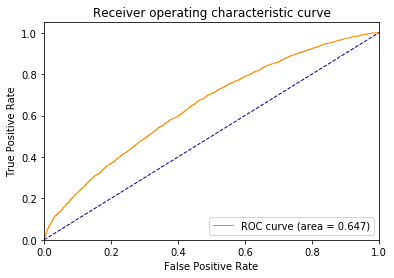

In [14]:
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

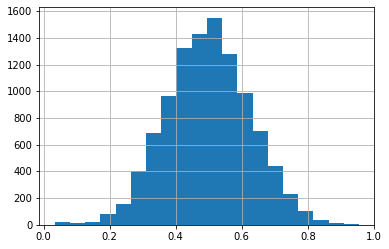

In [15]:
predicted = test_preds.reshape(-1)
pd.Series(predicted).hist(bins=20)
plt.show()

In [16]:
def probcats(nbins):
    df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy','lconf95','hconf95'])
    for pbot in np.linspace(0,1-1/nbins,nbins):
        ptop = pbot+1/nbins
        mask = (predicted>=pbot)&(predicted<ptop)
        count = int(mask.sum())
        if count>0:
            actual = pd.Series(y_test)[mask].values
            pred_prob = pd.Series(predicted)[mask].values
            pred_bin = pred_prob>.5
            acc = accuracy_score(actual, pred_bin)
            nsucc = sum(actual==pred_bin)
            confint = proportion_confint(nsucc, count)
            minconf = confint[0]
            maxconf = confint[1]
        else:
            acc = np.nan
            minconf = np.nan
            maxconf = np.nan
        row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 
                            'accuracy':[acc], 'lconf95':[minconf], 'hconf95':[maxconf]})
        df_acc = pd.concat([df_acc, row], sort=False)
    return(df_acc.set_index(['minprob','maxprob']))
df_acc = probcats(10)
df_acc

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.0,0.1,30,0.900000,0.792648,1.000000
0.1,0.2,68,0.926471,0.864435,0.988506
0.2,0.3,483,0.755694,0.717375,0.794013
0.3,0.4,1724,0.645012,0.622424,0.667599
0.4,0.5,2981,0.533043,0.515133,0.550952
0.5,0.6,2964,0.540486,0.522545,0.558427
0.6,0.7,1597,0.638071,0.614502,0.661640
0.7,0.8,523,0.774379,0.738555,0.810202
0.8,0.9,76,0.855263,0.776162,0.934364


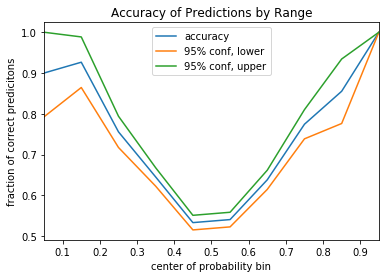

In [17]:
def display_perf(df):
    df = df.reset_index()
    df['avgprob'] = .5*(df.minprob + df.maxprob)
    ax = df.drop(['count','minprob','maxprob'],axis=1).set_index('avgprob').plot(
            title='Accuracy of Predictions by Range')
    ax.legend(labels=['accuracy', '95% conf, lower', '95% conf, upper'])
    ax.set(xlabel="center of probability bin", ylabel="fraction of correct predicitons")
    plt.show()
display_perf(df_acc)

In [18]:
probcats(4)

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.00,0.25,242,0.842975,0.797137,0.888814
0.25,0.50,5044,0.585250,0.571653,0.598846
0.50,0.75,4935,0.588450,0.574720,0.602180
0.75,1.00,229,0.834061,0.785877,0.882245
